In [57]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


/Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['arange', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [37]:
import arviz as az
import corner
import h5py
import lal
import pystan
import scipy.linalg as sl
import scipy.signal as sig
import scipy.stats as ss
import seaborn as sns
import qnm

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

In [6]:
ra = 1.95
dec = -1.27
psi = 0.82

tgps_H = 1126259462.423

dt_H = lal.TimeDelayFromEarthCenter(lal.cached_detector_by_prefix['H1'].location, ra, dec, lal.LIGOTimeGPS(tgps))
dt_L = lal.TimeDelayFromEarthCenter(lal.cached_detector_by_prefix['L1'].location, ra, dec, lal.LIGOTimeGPS(tgps))

tgps_L = tgps_H - dt_H + dt_L

gmst = lal.GreenwichMeanSiderealTime(lal.LIGOTimeGPS(tgps_H))
iota = pi
FpH, FcH = lal.ComputeDetAMResponse(lal.cached_detector_by_prefix['H1'].response, ra, dec, psi, gmst)
FpL, FcL = lal.ComputeDetAMResponse(lal.cached_detector_by_prefix['L1'].response, ra, dec, psi, gmst)

In [7]:
with h5py.File('H-H1_LOSC_4_V2-1126259446-32.hdf5', 'r') as f:
    Hstrain = array(f['strain/Strain'])
    T0 = f['meta/GPSstart'][()]
    Hts = linspace(T0, T0+32-1.0/4096, Hstrain.shape[0])

with h5py.File('L-L1_LOSC_4_V2-1126259446-32.hdf5', 'r') as f:
    Lstrain = array(f['strain/Strain'])
    T0 = f['meta/GPSstart'][()]
    Lts = linspace(T0, T0+32-1/4096, Lstrain.shape[0])
    
fny = 1.0/(Hts[1]-Hts[0])/2.0

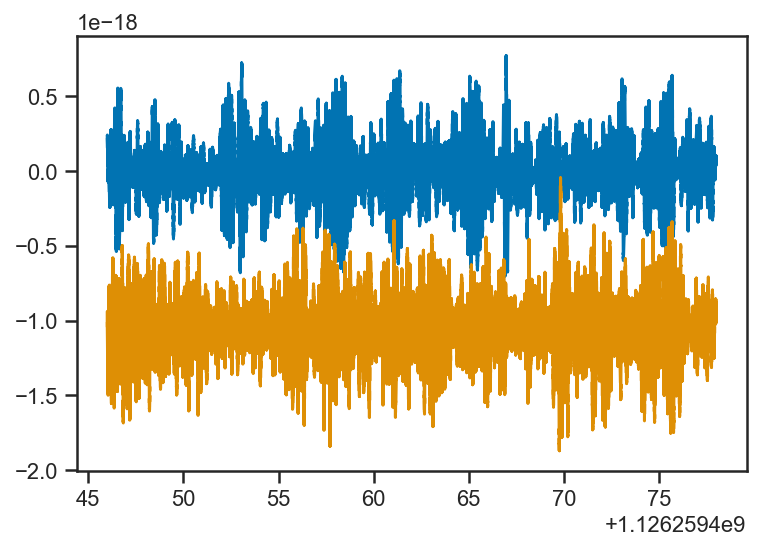

In [8]:
plot(Hts, Hstrain, label='H')
plot(Lts, Lstrain, label='L')

In [131]:
b, a = sig.butter(4, [32/fny, 1024/fny], btype='bandpass', output='ba')
Hfilt = sig.filtfilt(b, a, Hstrain)[::2]
Lfilt = sig.filtfilt(b, a, Lstrain)[::2]
Htsfilt = Hts[::2]
Ltsfilt = Lts[::2]

I0H = where(tgps_H > Htsfilt)[0][-1]+1
I0L = where(tgps_L > Ltsfilt)[0][-1]+1
Nanalyze = 128
Tanalyze = Nanalyze*(Htsfilt[1]-Htsfilt[0])
print('Will analyze {:.3f} s of data'.format(Tanalyze))

Will analyze 0.062 s of data


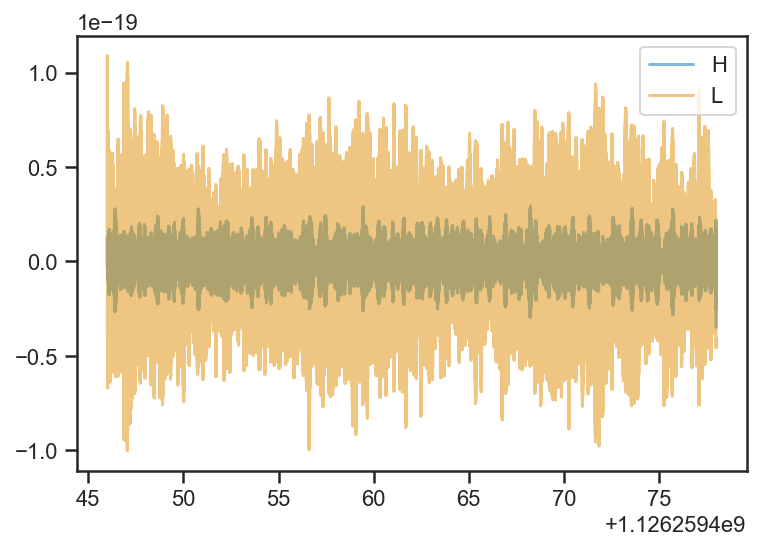

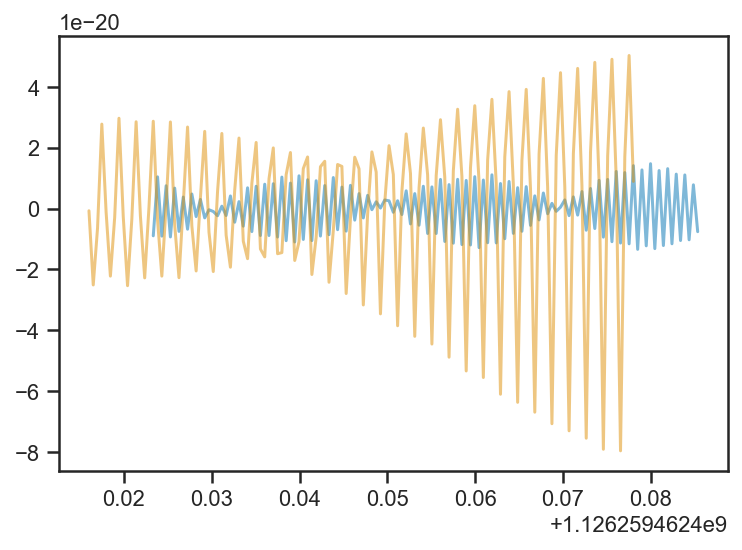

In [132]:
plot(Htsfilt, Hfilt, label='H', alpha=0.5)
plot(Ltsfilt, Lfilt, label='L', alpha=0.5)

legend(loc='best')

figure()
plot(Htsfilt[I0H:I0H+Nanalyze], Hfilt[I0H:I0H+Nanalyze], label='H', alpha=0.5)
plot(Ltsfilt[I0L:I0L+Nanalyze], Lfilt[I0L:I0L+Nanalyze], label='L', alpha=0.5)

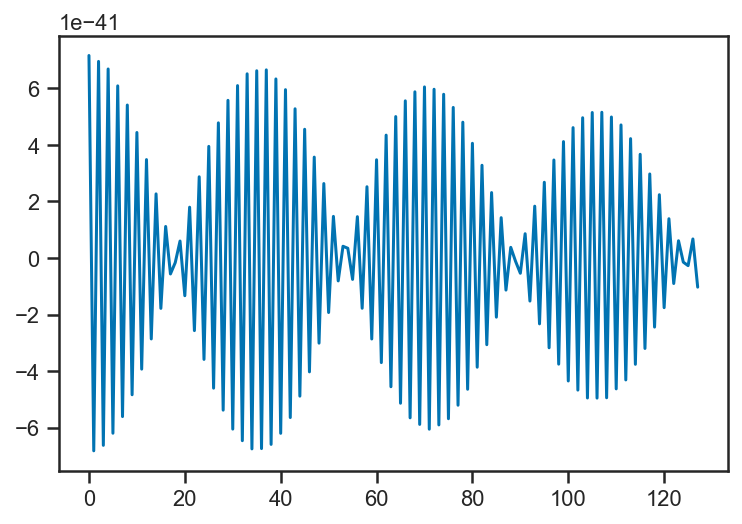

In [133]:
Hrho = sig.correlate(Hfilt, Hfilt)/Hfilt.shape[0]
Hrho = ifftshift(Hrho)
plot(Hrho[:Nanalyze])

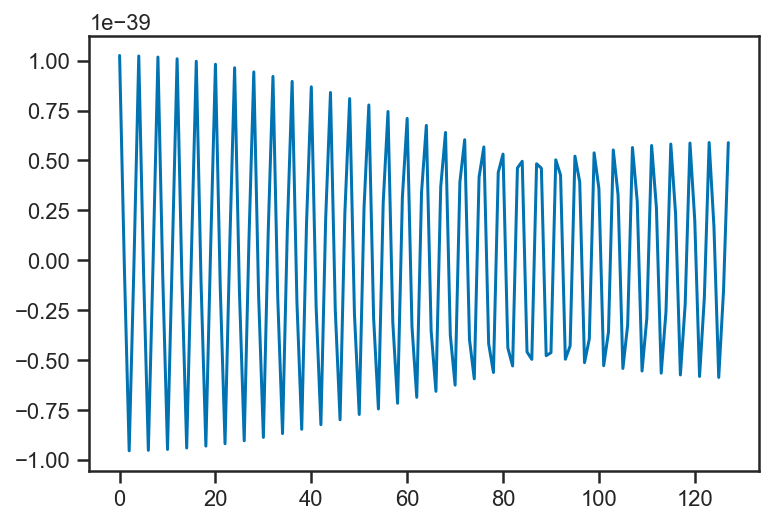

In [134]:
Lrho = sig.correlate(Lfilt, Lfilt)/Lfilt.shape[0]
Lrho = ifftshift(Lrho)
plot(Lrho[:Nanalyze])

In [135]:
HC = sl.toeplitz(Hrho[:Nanalyze])
HCorr = sl.toeplitz(HC[0,:]/HC[0,0])
HL = np.linalg.cholesky(HC)
HCorrL = np.linalg.cholesky(HCorr)

LC = sl.toeplitz(Lrho[:Nanalyze])
LCorr = sl.toeplitz(LC[0,:]/LC[0,0])
LL = np.linalg.cholesky(LC)
LCorrL = np.linalg.cholesky(LCorr)

This is something like the GW150914 plot: whitened data, with L shifted and inverted.

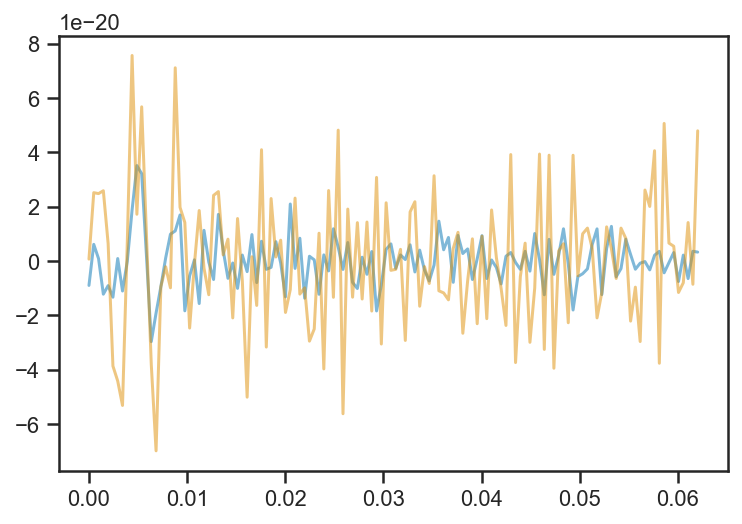

In [136]:
t = (Htsfilt[1]-Htsfilt[0])*arange(Nanalyze)
plot(t, np.linalg.solve(HCorrL, Hfilt[I0H:I0H+Nanalyze]), label='H', alpha=0.5)
plot(t, -np.linalg.solve(LCorrL, Lfilt[I0L:I0L+Nanalyze]), label='L', alpha=0.5)

In [137]:
x = randn(Nanalyze)
bHc = sl.cho_solve((HL, True), x)
bHt = sl.solve_toeplitz(Hrho[:Nanalyze], x)

In [138]:
x = randn(Nanalyze)
bLc = sl.cho_solve((LL, True), x)
bLt = sl.solve_toeplitz(Lrho[:Nanalyze], x)

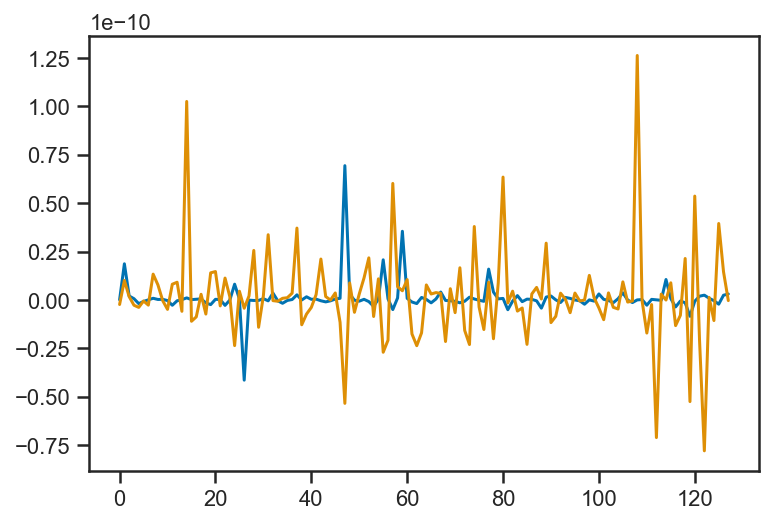

In [139]:
plot(2.0*(bHc-bHt)/(np.abs(bHc) + np.abs(bHt)))
plot(2.0*(bLc-bLt)/(np.abs(bLc) + np.abs(bLt)))

In [140]:
fref = 2.98e3 # Hz, at 68 MSun
chi0 = 0.69

g220 = qnm.modes_cache(-2, 2, 2, 0)
omega, _, _ = g220(a=chi0)
f0 = real(omega)/(2*pi) * fref
gamma0 = abs(imag(omega)) * fref

g221 = qnm.modes_cache(-2, 2, 2, 1)
omega, _, _ = g221(a=chi0)
f1 = real(omega)/(2*pi) * fref
gamma1 = abs(imag(omega)) * fref

g222 = qnm.modes_cache(-2, 2, 2, 1)
omega, _, _ = g222(a=chi0)
f2 = real(omega)/(2*pi) * fref
gamma2 = abs(imag(omega)) * fref

print('Given estimated tau0, expect signal to be down by exp(-{:.1f}) by end of data'.format(gamma0*Tanalyze))

Given estimated tau0, expect signal to be down by exp(-15.1) by end of data


In [130]:
model = pystan.StanModel(file='ringdown.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_329081498f812b1077869ec0381a9169 NOW.
/Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmp0luq52l4/stanfit4anon_model_329081498f812b1077869ec0381a9169_8410991341346189310.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [143]:
data = {
    'nobs': 2,
    'nsamp': Nanalyze,
    'nmode': 2,
    
    't0': [tgps_H, tgps_L],
    'ts': [Htsfilt[I0H:I0H+Nanalyze], Ltsfilt[I0L:I0L+Nanalyze]],
    'strain': [Hfilt[I0H:I0H+Nanalyze], -Lfilt[I0L:I0L+Nanalyze]],
    'L': [HL, LL],
    
    'mu_logf': [log(f0), log(f1)],#, log(f2)],
    'sigma_logf': [0.5, 0.5],#, 0.5],
    
    'mu_loggamma': [log(gamma0), log(gamma1)],#, log(gamma2)],
    'sigma_loggamma': [0.5, 0.5],#, 0.5],
    
    'FpFc': [[FpH, FcH], [FpL, FcL]],
    
    'Amax': 1e-20
}

In [152]:
n = 1
fit = model.sampling(data=data, iter=n*2000, thin=n)

/Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [153]:
fit = az.convert_to_inference_data(fit)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12f2a4cc0>,
      dtype=object)

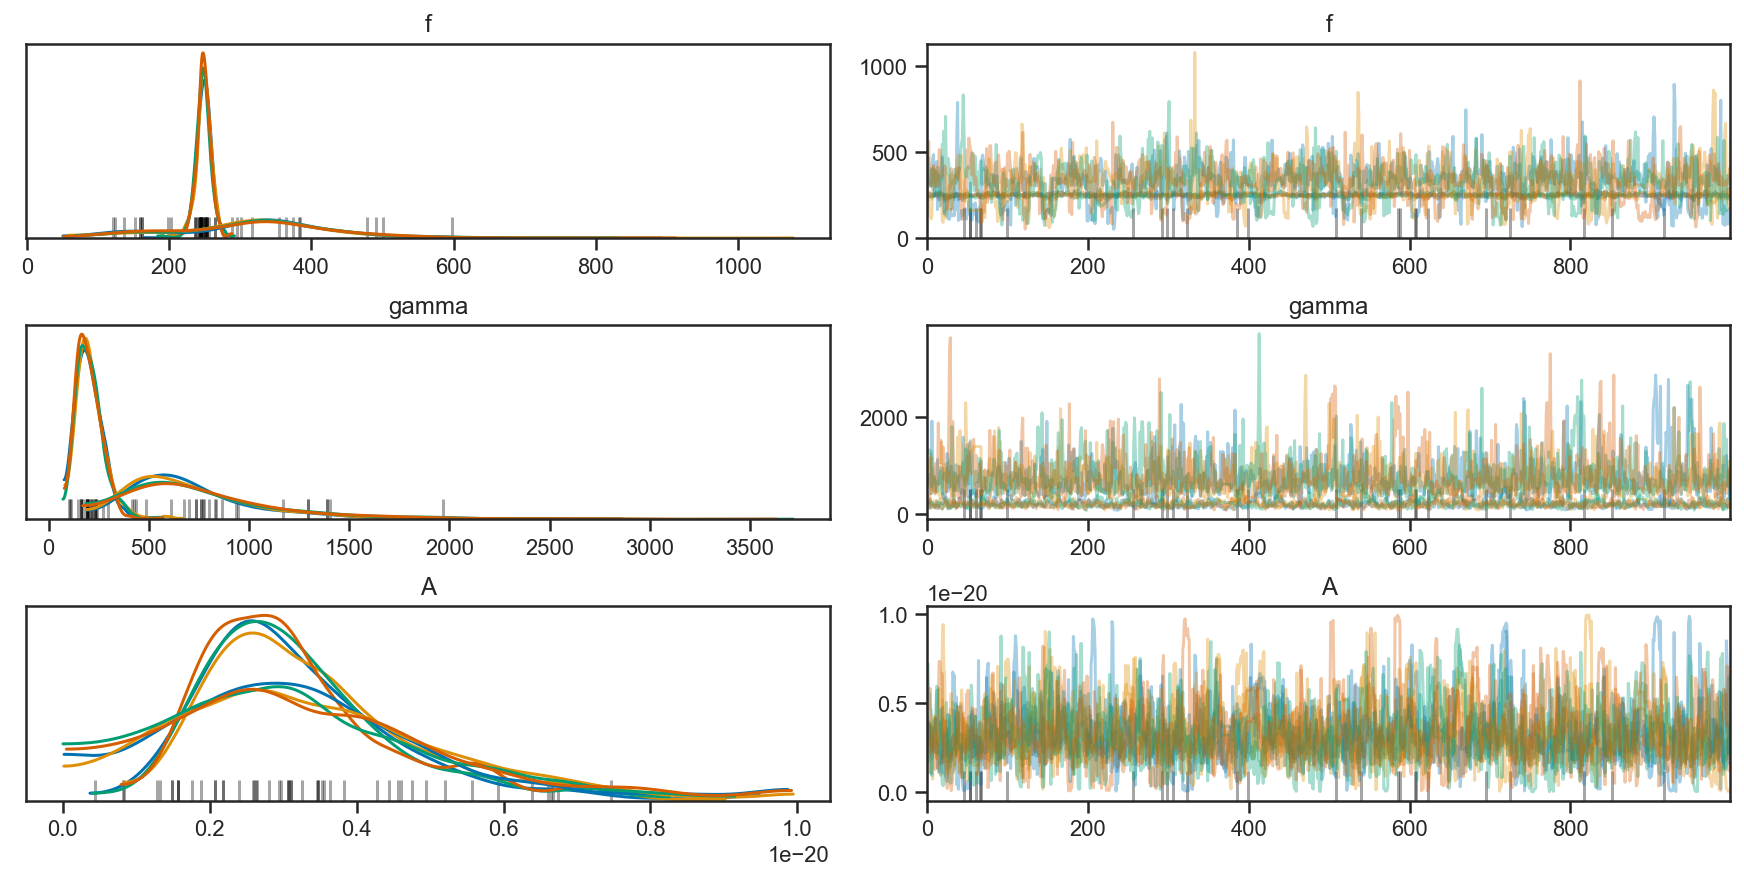

In [154]:
az.plot_trace(fit, var_names=['f', 'gamma', 'A'], compact=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12a7e0940>,
      dtype=object)

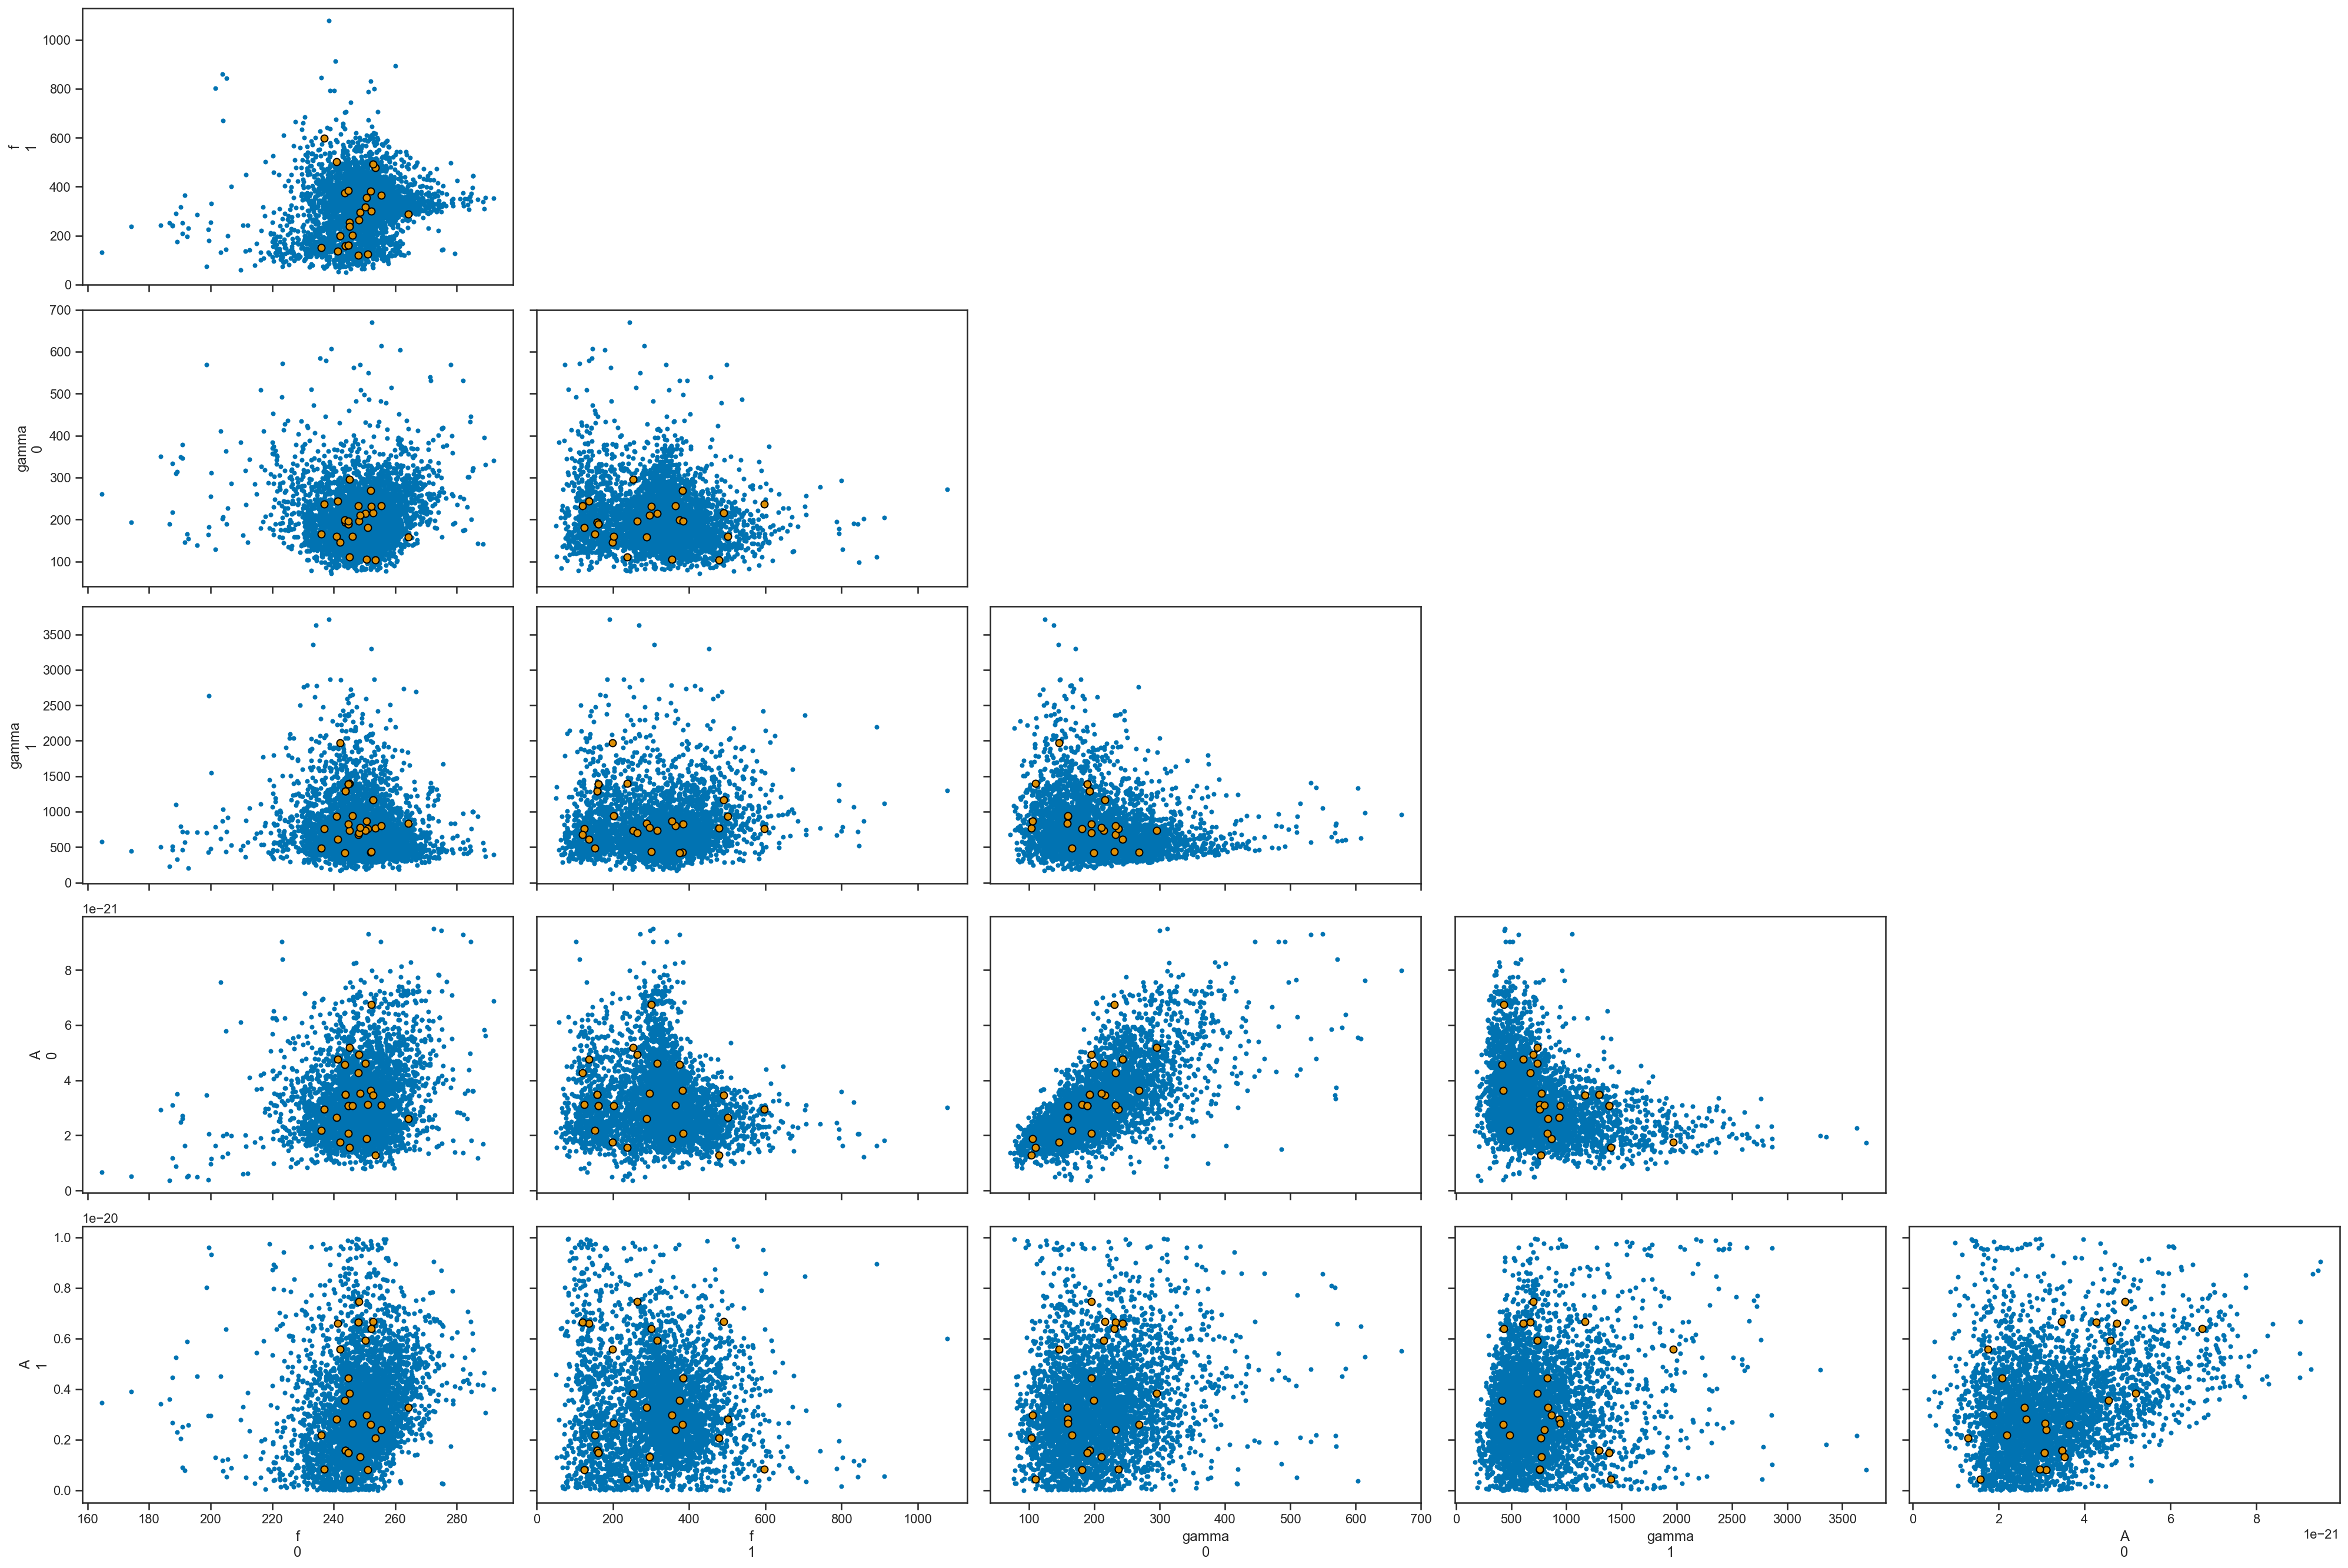

In [155]:
az.plot_pair(fit, var_names=['f', 'gamma', 'A'], divergences=True)

In [156]:
mean(fit.posterior.f.values[:,:,0]), std(fit.posterior.f.values[:,:,0]), std(log(fit.posterior.f.values[:,:,0]))

(248.30727130066666, 11.037324166220282, 0.045595580898719075)

In [157]:
mean(fit.posterior.f.values[:,:,1]), std(fit.posterior.f.values[:,:,1]), std(log(fit.posterior.f.values[:,:,1]))

(318.5663216438226, 112.69124427803365, 0.41287814556348174)

In [158]:
std(log(fit.posterior.f.values[:,:,0])), std(log(fit.posterior.gamma.values[:,:,0]))

(0.045595580898719075, 0.3214087842907015)

In [159]:
std(log(fit.posterior.f.values[:,:,1])), std(log(fit.posterior.gamma.values[:,:,1]))

(0.41287814556348174, 0.4539164874740842)

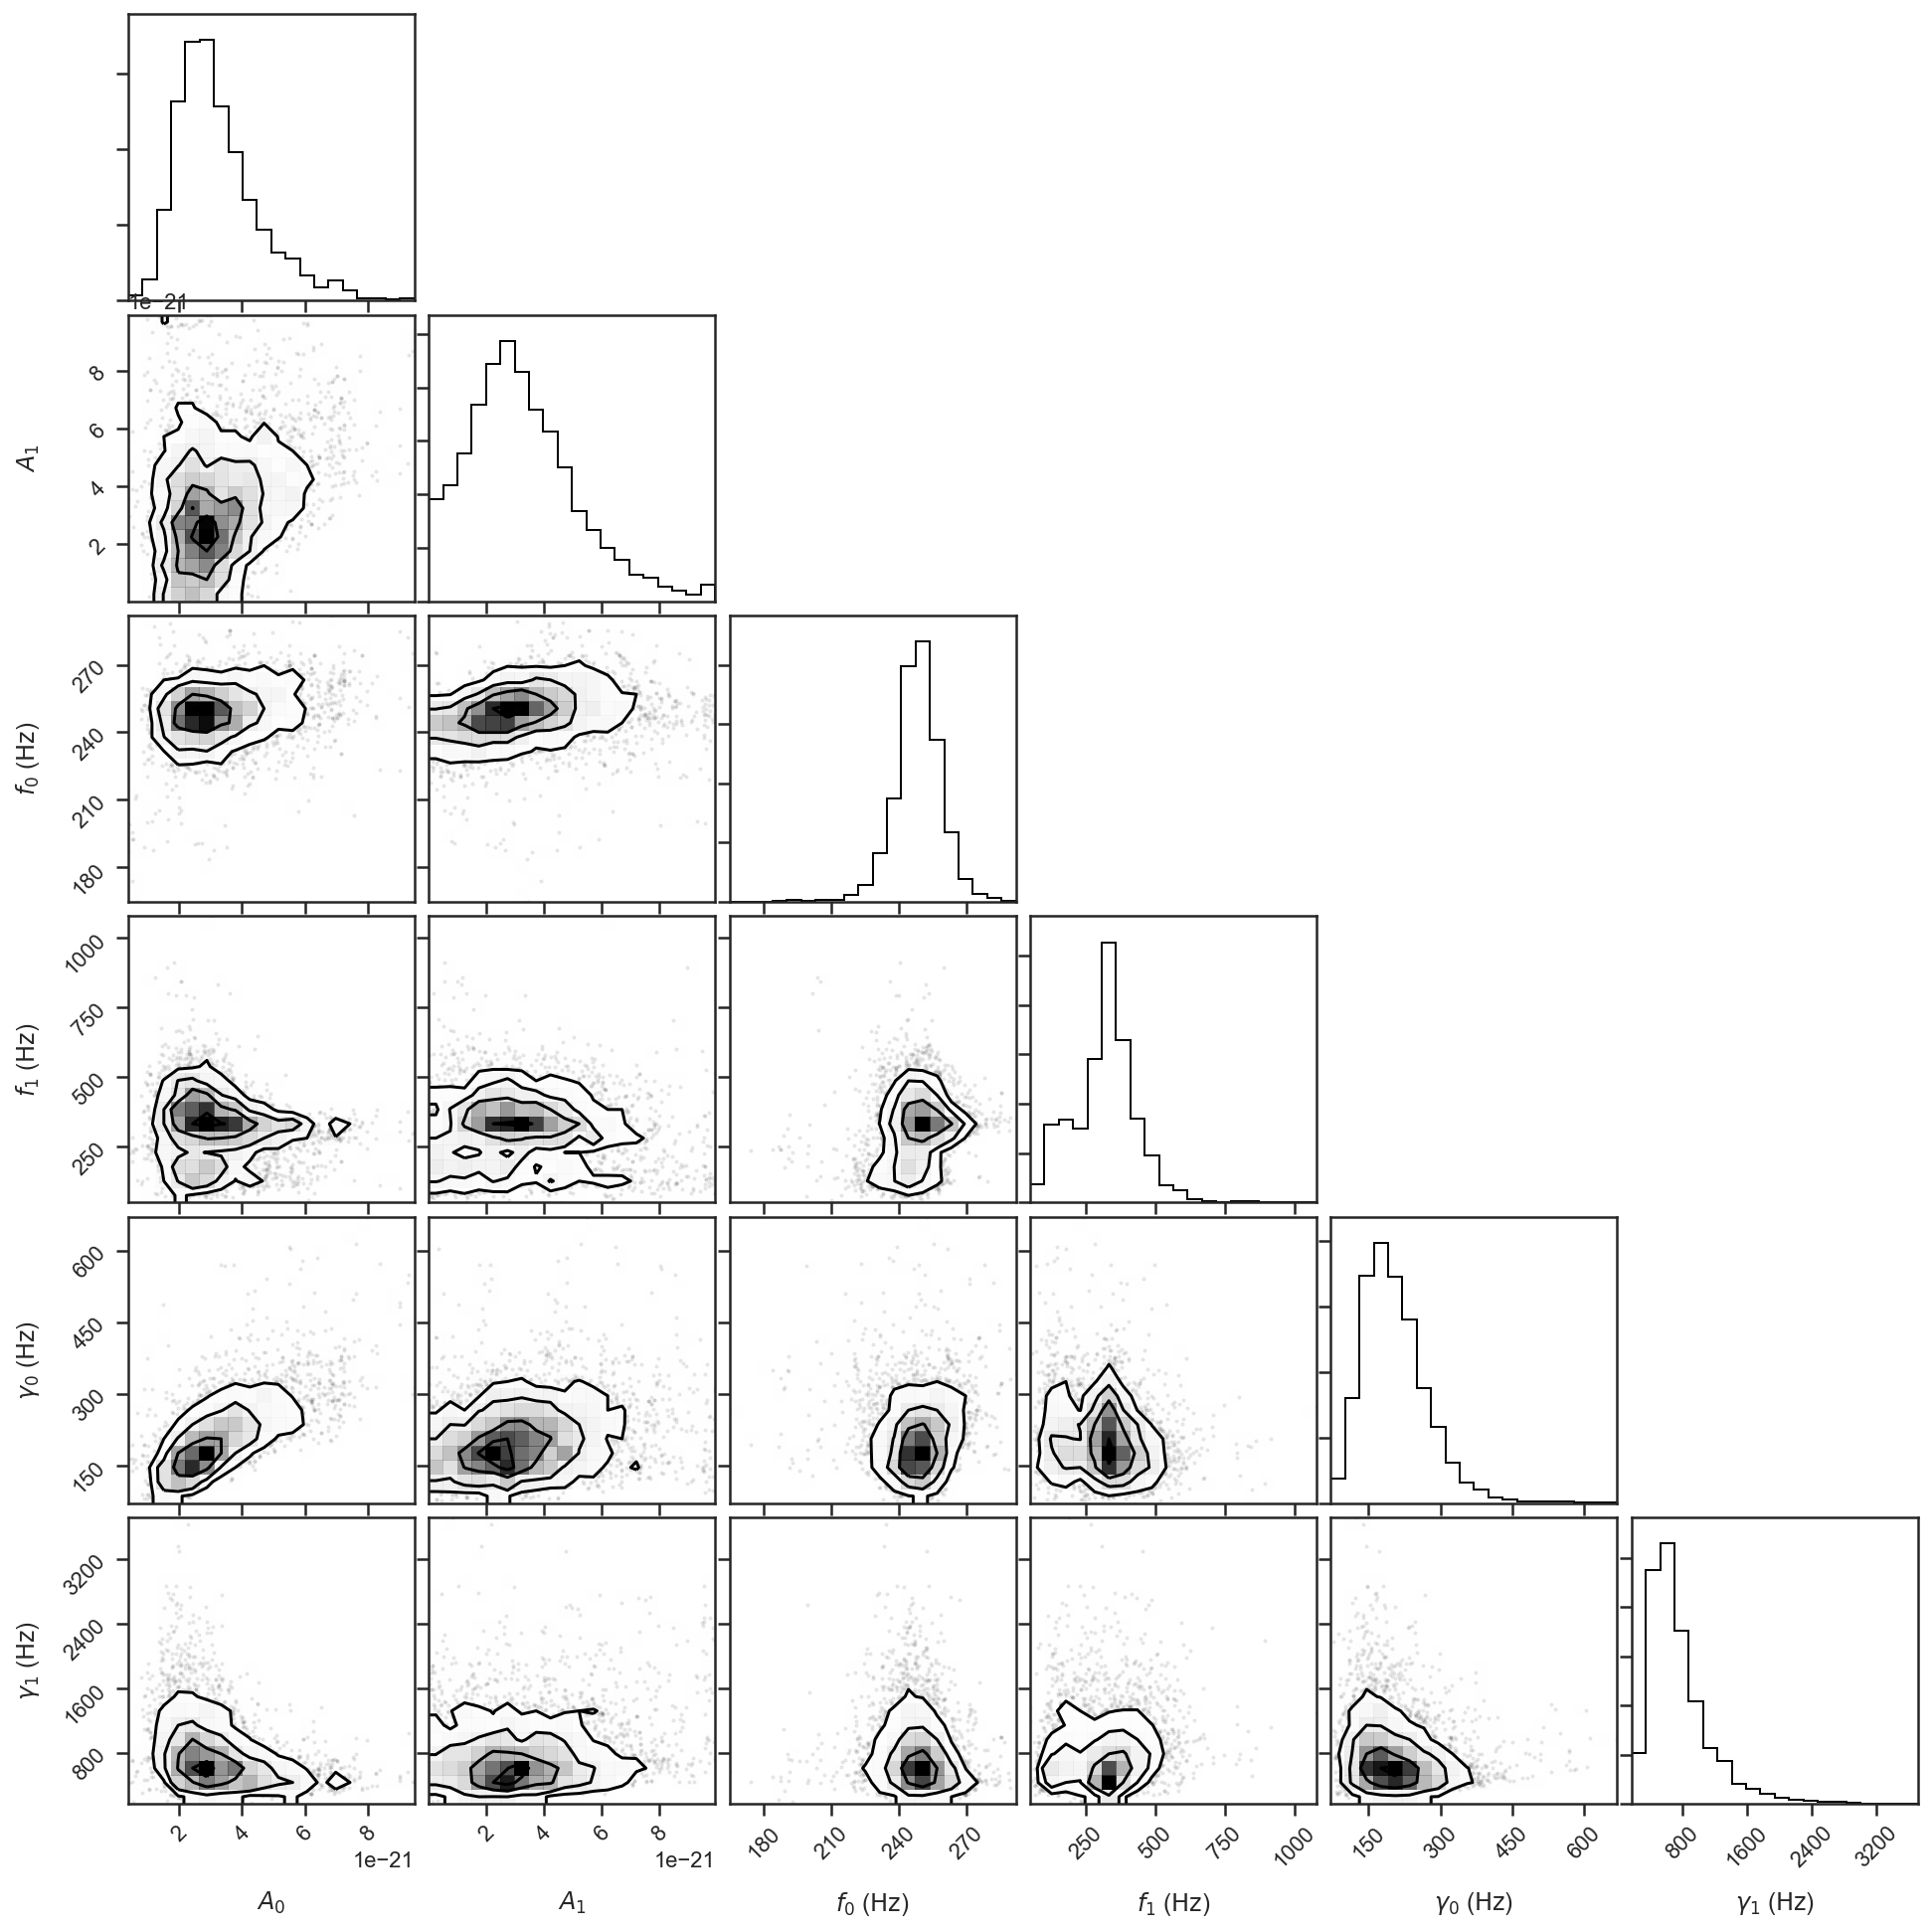

In [160]:
pts = column_stack((fit.posterior.A.values[:,:,0].flatten(), fit.posterior.A.values[:,:,1].flatten(),
                    fit.posterior.f.values[:,:,0].flatten(), fit.posterior.f.values[:,:,1].flatten(),
                    fit.posterior.gamma.values[:,:,0].flatten(), fit.posterior.gamma.values[:,:,1].flatten()))
names = [r'$A_0$', r'$A_1$',
         r'$f_0$ ($\mathrm{Hz}$)', r'$f_1$ ($\mathrm{Hz}$)',
         r'$\gamma_0$ ($\mathrm{Hz}$)', r'$\gamma_1$ ($\mathrm{Hz}$)']
corner.corner(pts, labels=names);

In [161]:
chis = linspace(0, 1, 100)[1:-1]

In [162]:
freqs0 = array([fref*real(g220(c)[0])/(2*pi) for c in chis])
freqs1 = array([fref*real(g221(c)[0])/(2*pi) for c in chis])

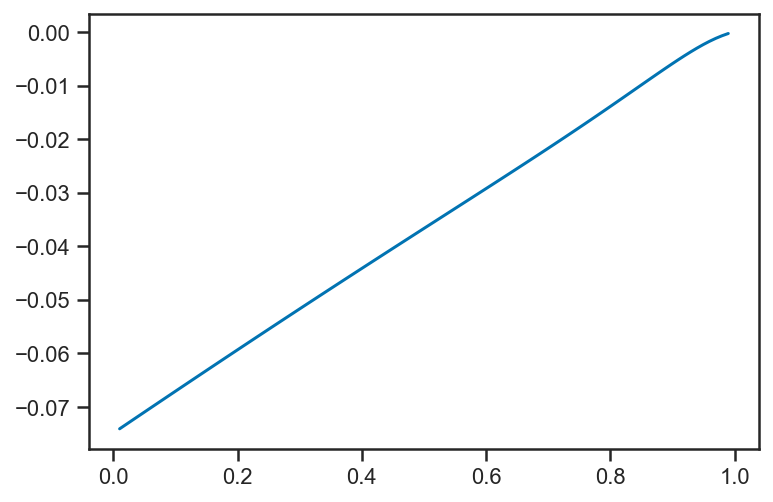

In [163]:
plot(chis, log(freqs1/freqs0))

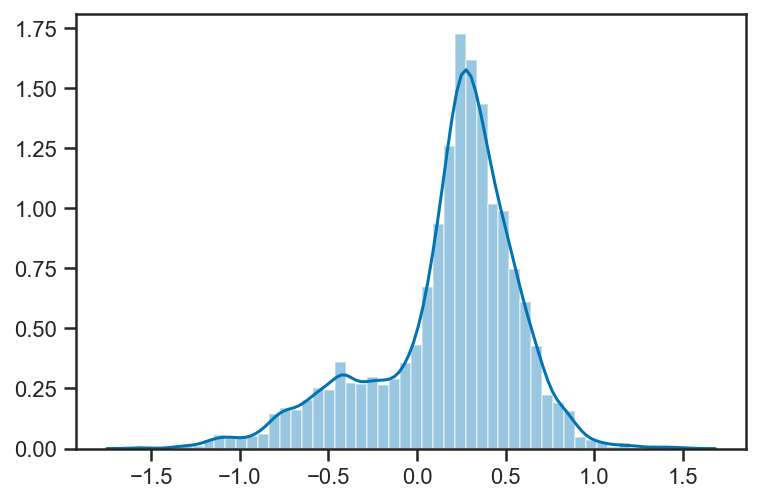

In [164]:
sns.distplot(log(fit.posterior.f.values[:,:,1].flatten()/fit.posterior.f.values[:,:,0].flatten()))

In [165]:
fit.posterior.h_det.values.shape

(4, 1000, 2, 128)

<ErrorbarContainer object of 3 artists>

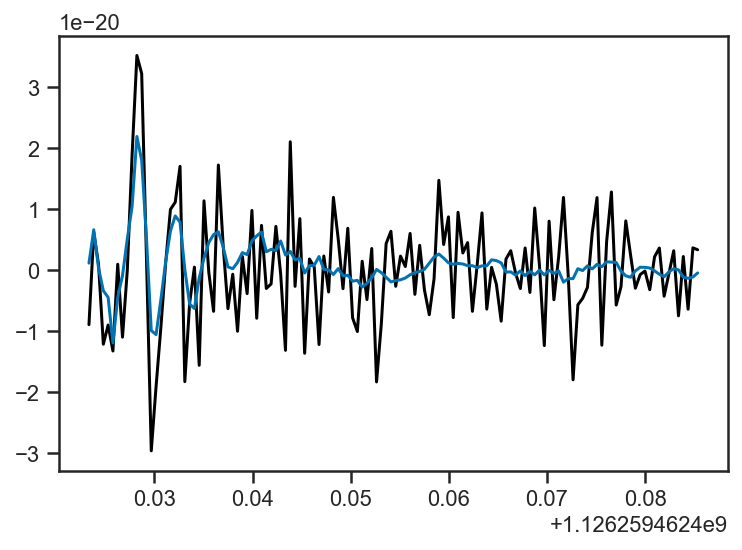

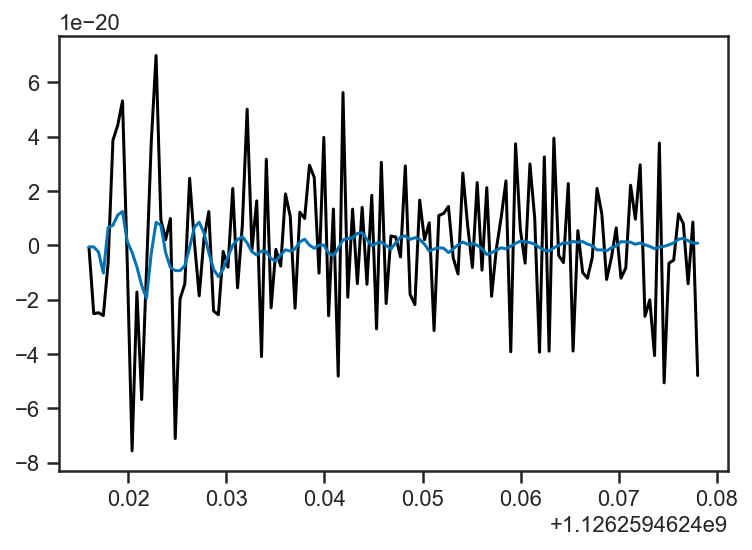

In [167]:
plot(Htsfilt[I0H:I0H+Nanalyze], np.linalg.solve(HCorrL, Hfilt[I0H:I0H+Nanalyze]), '-k')
errorbar(Htsfilt[I0H:I0H+Nanalyze], np.linalg.solve(HCorrL, mean(fit.posterior.h_det.values[:,:,0,:], axis=(0,1))))

figure()

plot(Ltsfilt[I0L:I0L+Nanalyze], np.linalg.solve(LCorrL, Lfilt[I0L:I0L+Nanalyze]), '-k')
errorbar(Ltsfilt[I0L:I0L+Nanalyze], np.linalg.solve(LCorrL, mean(fit.posterior.h_det.values[:,:,1,:], axis=(0,1))))